In [94]:
# third party
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy
import torch

In [ ]:
# Filenames and directories
MODULE_DIR = "other_prediction_functions"
INPUT_SQ_DIR = "a. Input time series sequences"
VAR_OUT_DIR = (
    "d. RNN variables (temp)"  # same as in Matlab repo, could be improved later: load from json and remove RNN
)

USE_ETH_DATA_AS_TRAINING = (
    False  # if True, use ETH data as training set, otherwise use the first 1000 sequences of the test set
)

horizon = 2
n_models = 2
num_epochs = 300
learning_rate = 0.0001
early_stop_patience = 20
print_every = 10
init_seed = 42  # the seed of the first model to train
selected_device = "cuda"  # choose between "cuda" or "cpu"

# Model parameters
d_model = 16  # Embedding dimension
nhead = 2  # Number of heads in multi-head attention
num_layers = 2  # Number of transformer layers
dim_feedforward = 16  # Dimension of feedforward network
dropout = 0.5  # Dropout rate (now explicit)
final_layer_dim = None  # Dimension of the final hidden linear layer, None sets it to geometric mean of input and output

# Hyperparameters
seq_length = 24  # Input sequence length
training_fraction = 0.8  # Fraction of data used for training
batch_size = 32

# Index of the model we want to test and for which we plot predictions - cf test section of the notebook
test_model_idx = 0

# Index of the sequence in the test set we use as an example for testing - cf test section of the notebook
test_sequence_idx = 0

In [96]:
folders = {
    "dev_folders": [
        "2. sq sl010 sag Xcs=125 3 cpts 2024 normalised",
        "3. sq sl010 sag Xcs=80 3 cpts 2024 normalised",
        "4. sq sl014 sag Xcs=165 3 cpts 2024 normalised",
        "5. sq sl014 sag Xcs=95 3 cpts 2024 normalised",
    ],
    "test_folders": [
        "2020-11-10_KS81_Nav_Pur_1_3_cpts",
        "2020-11-12_QN76_Nav_Pur_1_3_cpts",
        "2020-11-17_CS31_Nav_Pur_2_3_cpts",
        "2020-11-17_JY02_Nav_Pur_2_3_cpts",
        "2020-11-23_ON65_Nav_Pur_2_3_cpts",
        "2020-11-23_PS11_Nav_Pur_1_3_cpts",
        "2020-11-25_II29_Nav_Pur_1_3_cpts",
        "2020-11-26_NE38_Nav_Pur_1_3_cpts",
    ],
}

# Resampling parameters
dev_freq_hz = 3.18
test_freq_hz = 6.0

if not USE_ETH_DATA_AS_TRAINING:
    folders["dev_folders"], folders["test_folders"] = folders["test_folders"], folders["dev_folders"]
    dev_freq_hz, test_freq_hz = test_freq_hz, dev_freq_hz

In [97]:
import sys
import os

# Get the current notebook's directory
notebook_dir = os.getcwd()

# Construct the relative path to the module
module_dir = os.path.join(notebook_dir, "..", MODULE_DIR)

# Add to sys.path if not already included
if module_dir not in sys.path:
    sys.path.append(module_dir)

# Importing the module for transformer forecasting
import transformers_forecasting as tf  # type: ignore

Loading the data


In [98]:
# Loading data
workspace_dir = os.path.dirname(notebook_dir)
for folder_type, folders_list in folders.items():
    folders[folder_type] = [os.path.join(workspace_dir, INPUT_SQ_DIR, folder) for folder in folders_list]

raw_data, n_features = tf.load_dev_test_data(**folders)

Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/2020-11-10_KS81_Nav_Pur_1_3_cpts...
Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/2020-11-12_QN76_Nav_Pur_1_3_cpts...
Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/2020-11-17_CS31_Nav_Pur_2_3_cpts...
Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/2020-11-17_JY02_Nav_Pur_2_3_cpts...
Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/2020-11-23_ON65_Nav_Pur_2_3_cpts...
Loading development data from /home/mpohl/dev/2D-MR-image-prediction/Time_series_forecasting/a. Input time series sequences/2020-11-23_PS11_Nav_Pur_1_3_cpts...
Loading development data from /home/mpoh

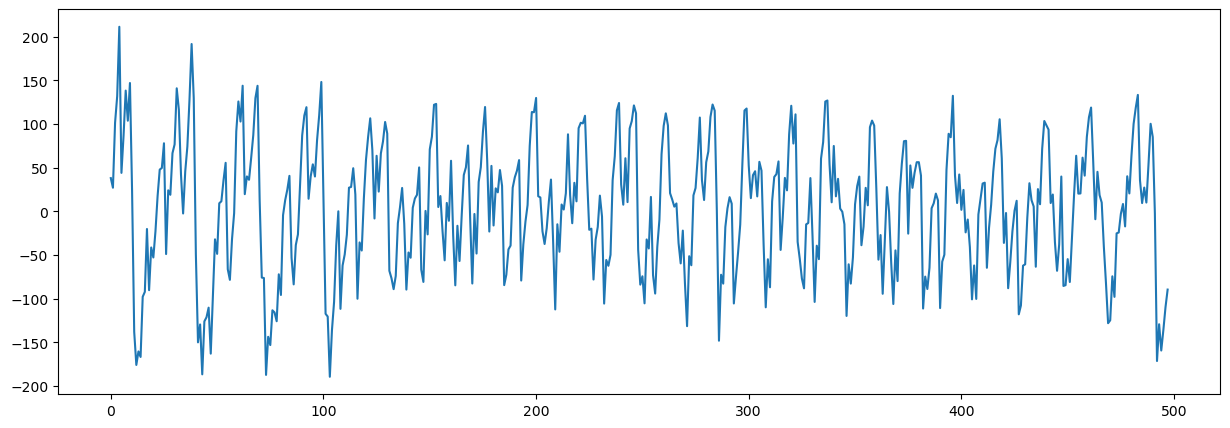

In [99]:
# plotting the original data - modify the sequence index and coordinate you want to plot
sequence_idx = 0
crd_idx = 1

plt.figure(figsize=(15, 5))
plt.plot(raw_data["dev_data"][sequence_idx][crd_idx].T)
plt.show()

Resampling the data


In [100]:
# Resample data if frequencies differ
if dev_freq_hz != test_freq_hz:
    resampled_dev_data = tf.resample_data_poly(raw_data["dev_data"], dev_freq_hz, test_freq_hz)

resampled_data = raw_data.copy()
resampled_data["dev_data"] = resampled_dev_data

Resampling with ratio 6.0/3.18 = 100/53
Resampled dev signal 1: 498 → 264 samples (expected ~263)
Resampled dev signal 2: 498 → 264 samples (expected ~263)
Resampled dev signal 3: 498 → 264 samples (expected ~263)
Resampled dev signal 4: 498 → 264 samples (expected ~263)
Resampled dev signal 5: 498 → 264 samples (expected ~263)
Resampled dev signal 6: 498 → 264 samples (expected ~263)
Resampled dev signal 7: 498 → 264 samples (expected ~263)
Resampled dev signal 8: 498 → 264 samples (expected ~263)


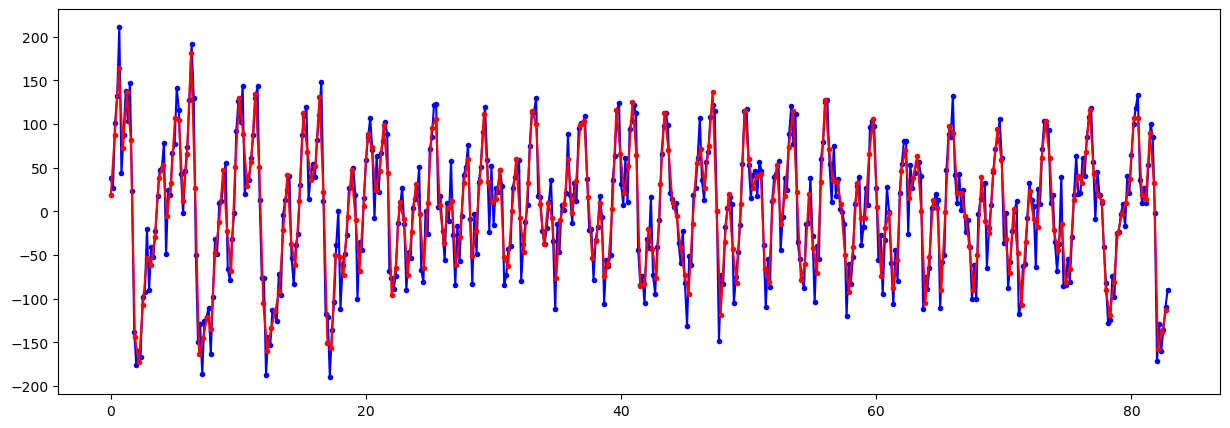

In [101]:
# plotting the original against the resampled data to check that resampling worked
org_sq = raw_data["dev_data"][sequence_idx][crd_idx].T
resampled_sq = resampled_dev_data[sequence_idx][crd_idx].T

# plot inspired by https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html
t = np.linspace(0, (1 / dev_freq_hz) * org_sq.shape[0], org_sq.shape[0], endpoint=False)
t_new = np.linspace(0, (1 / test_freq_hz) * resampled_sq.shape[0], resampled_sq.shape[0], endpoint=False)

plt.figure(figsize=(15, 5))
plt.plot(
    t, raw_data["dev_data"][sequence_idx][crd_idx].T, "b.-", t_new, resampled_dev_data[sequence_idx][crd_idx].T, "r.-"
)
plt.show()

In [102]:
# Preprocessing data and splitting the data into pairs of unput and target values
standardized_data, scaler = tf.preprocess_data(resampled_data, horizon, seq_length, training_fraction)

# Getting pytorch data loaders
data_loaders = tf.get_population_data_loaders(standardized_data, batch_size=batch_size)

train set: Added 186 sequences
train set: Added 186 sequences
train set: Added 186 sequences
train set: Added 186 sequences
train set: Added 186 sequences
train set: Added 186 sequences
train set: Added 186 sequences
train set: Added 186 sequences
val set: Added 28 sequences
val set: Added 28 sequences
val set: Added 28 sequences
val set: Added 28 sequences
val set: Added 28 sequences
val set: Added 28 sequences
val set: Added 28 sequences
val set: Added 28 sequences
test set: Added 175 sequences
test set: Added 175 sequences
test set: Added 175 sequences
test set: Added 175 sequences
Train loader: 1488 sequences
Val loader: 224 sequences
Test loader: 700 sequences


Training multiple models ("n_runs") to account for stochasticity


In [103]:
# creating model output director if not already present
model_output_dir = os.path.join(workspace_dir, VAR_OUT_DIR)
Path(model_output_dir).mkdir(parents=True, exist_ok=True)

# Get the device
device = tf.get_device(selected_device)
print(f"Using device: {device}")

# Setting up the config dictionary, containing variables for initializing the transformer
config = {
    "n_features": n_features,
    "output_dim": n_features,
    "seq_length": seq_length,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "dim_feedforward": dim_feedforward,
    "dropout": dropout,
    "final_layer_dim": final_layer_dim,
    "seed": init_seed,
}

horizon_results = tf.train_multiple_models(
    config,
    device=device,
    data_loaders=data_loaders,
    horizon=horizon,
    n_models=n_models,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    early_stop_patience=early_stop_patience,
    save_dir=model_output_dir,
    print_every=print_every,
)

CUDA is not available. Using CPU instead.
Using device: cpu

Training model 1/3 for horizon=2
Epoch [10/300], Train Loss: 0.7022, Val Loss: 0.6999
Epoch [20/300], Train Loss: 0.5857, Val Loss: 0.6450
Epoch [30/300], Train Loss: 0.5162, Val Loss: 0.6376
Epoch [40/300], Train Loss: 0.4513, Val Loss: 0.6292
Epoch [50/300], Train Loss: 0.4219, Val Loss: 0.6091
Epoch [60/300], Train Loss: 0.3766, Val Loss: 0.6048
Epoch [70/300], Train Loss: 0.3491, Val Loss: 0.5948
Epoch [80/300], Train Loss: 0.3298, Val Loss: 0.5911
Epoch [90/300], Train Loss: 0.3136, Val Loss: 0.5844
Epoch [100/300], Train Loss: 0.2910, Val Loss: 0.5779
Epoch [110/300], Train Loss: 0.2803, Val Loss: 0.5739
Epoch [120/300], Train Loss: 0.2646, Val Loss: 0.5587
Epoch [130/300], Train Loss: 0.2561, Val Loss: 0.5641
Epoch [140/300], Train Loss: 0.2482, Val Loss: 0.5636
Epoch [150/300], Train Loss: 0.2348, Val Loss: 0.5613
Early stopping at epoch 159
Test Loss for Model 1: 7.9372
Model 1 saved to /home/mpohl/dev/2D-MR-image-pr

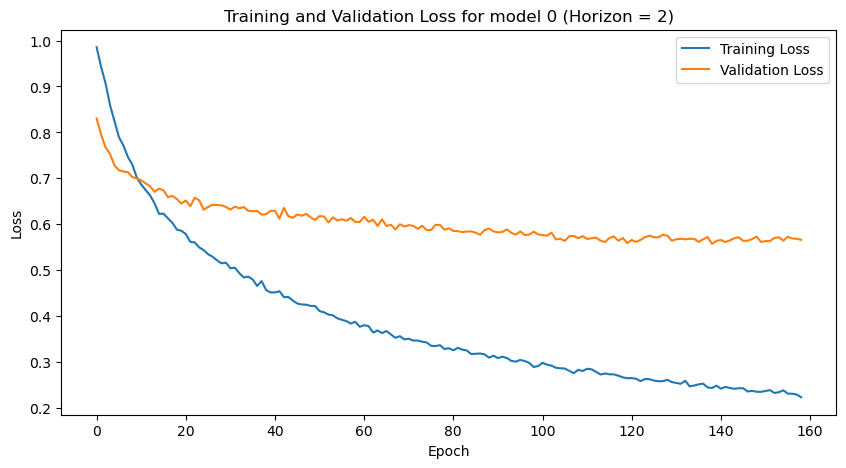

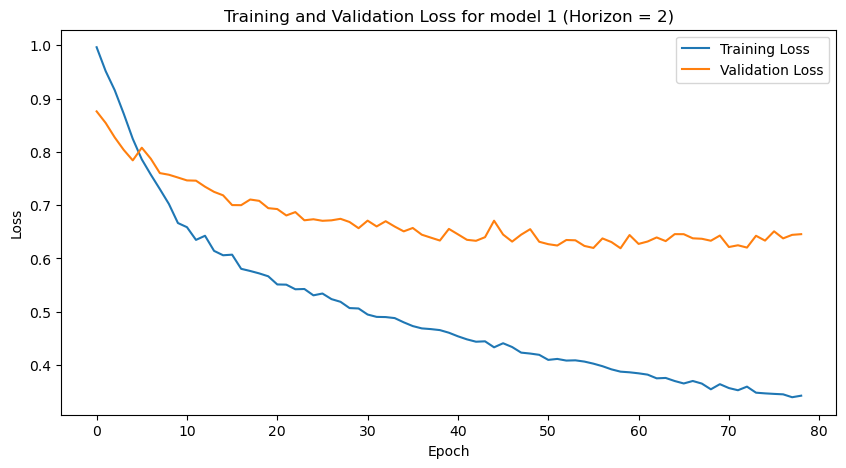

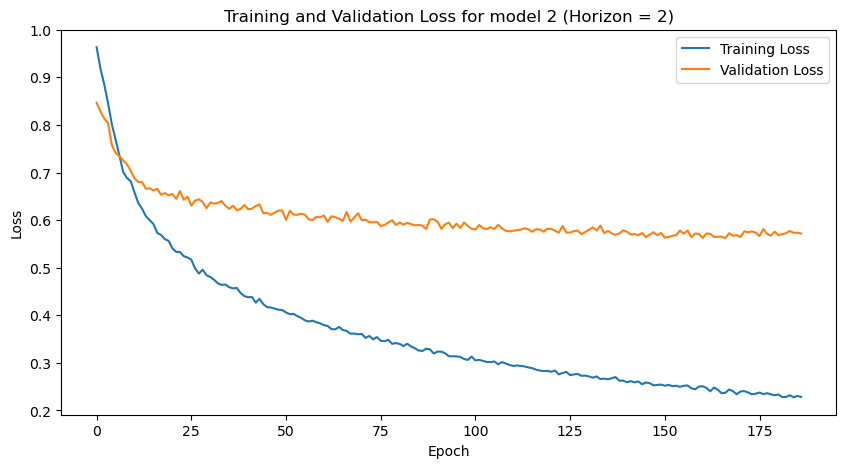

In [104]:
# Plot training and validation losses
for model_idx in range(n_models):
    plt.figure(figsize=(10, 5))
    plt.plot(horizon_results[model_idx]["training_history"]["train_losses"], label="Training Loss")
    plt.plot(horizon_results[model_idx]["training_history"]["val_losses"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss for model {model_idx} (Horizon = {horizon})")
    plt.legend()
    plt.show()

Evaluation on a particular test sequence


In [105]:
# Loading the specified model for prediction
model = tf.init_model(config)
model.load_state_dict(torch.load(horizon_results[test_model_idx]["model_path"], map_location=device))

input_sq_name = folders["test_folders"][test_sequence_idx].split("/")[-1]
print(f"Using data from {input_sq_name} for testing")

# I need to recreate the loader for the test data because data_loaders["test"] contains the test data for all the test
# sequences concatenated - one just need to try:
# test_predictions, test_targets, _ = tf.eval_model(model, data_loaders["test"], device)
# print(f"test_predictions shape: {test_predictions.shape}")
# print(f"test_targets shape: {test_targets.shape}")

# # First option: starting from scratch
# sq_filename = os.path.join(workspace_dir, INPUT_SQ_DIR, input_sq_name, tf.DATA_FILENAME)
# time_data_mat = scipy.io.loadmat(sq_filename)
# test_signals = time_data_mat["org_data"]
# n_samples_test = test_signals.shape[1]
# test_data_scaled = scaler.transform(test_signals.T)
# X_test, y_test, test_indices = tf.create_multidim_sequences(test_data_scaled.T, seq_length, horizon)

# Second option (shorter): using the standardized_data that I computed previously:
test_data_scaled = standardized_data["test"][test_sequence_idx]
X_test, y_test, test_indices = test_data_scaled["X"], test_data_scaled["y"], test_data_scaled["indices"]

test_loader = tf.get_data_loader(X_test, y_test, batch_size, shuffle=False)
test_predictions, test_targets, _ = tf.eval_model(model, test_loader, device)
print(f"test_predictions shape: {test_predictions.shape}")
print(f"test_targets shape: {test_targets.shape}")

# Inverse standardization
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
test_targets_rescaled = scaler.inverse_transform(test_targets)

Using data from 2. sq sl010 sag Xcs=125 3 cpts 2024 normalised for testing
test_predictions shape: (175, 3)
test_targets shape: (175, 3)


/tmp/ipykernel_57131/3336281946.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(horizon_results[test_model_idx]["model_path"], map_locat

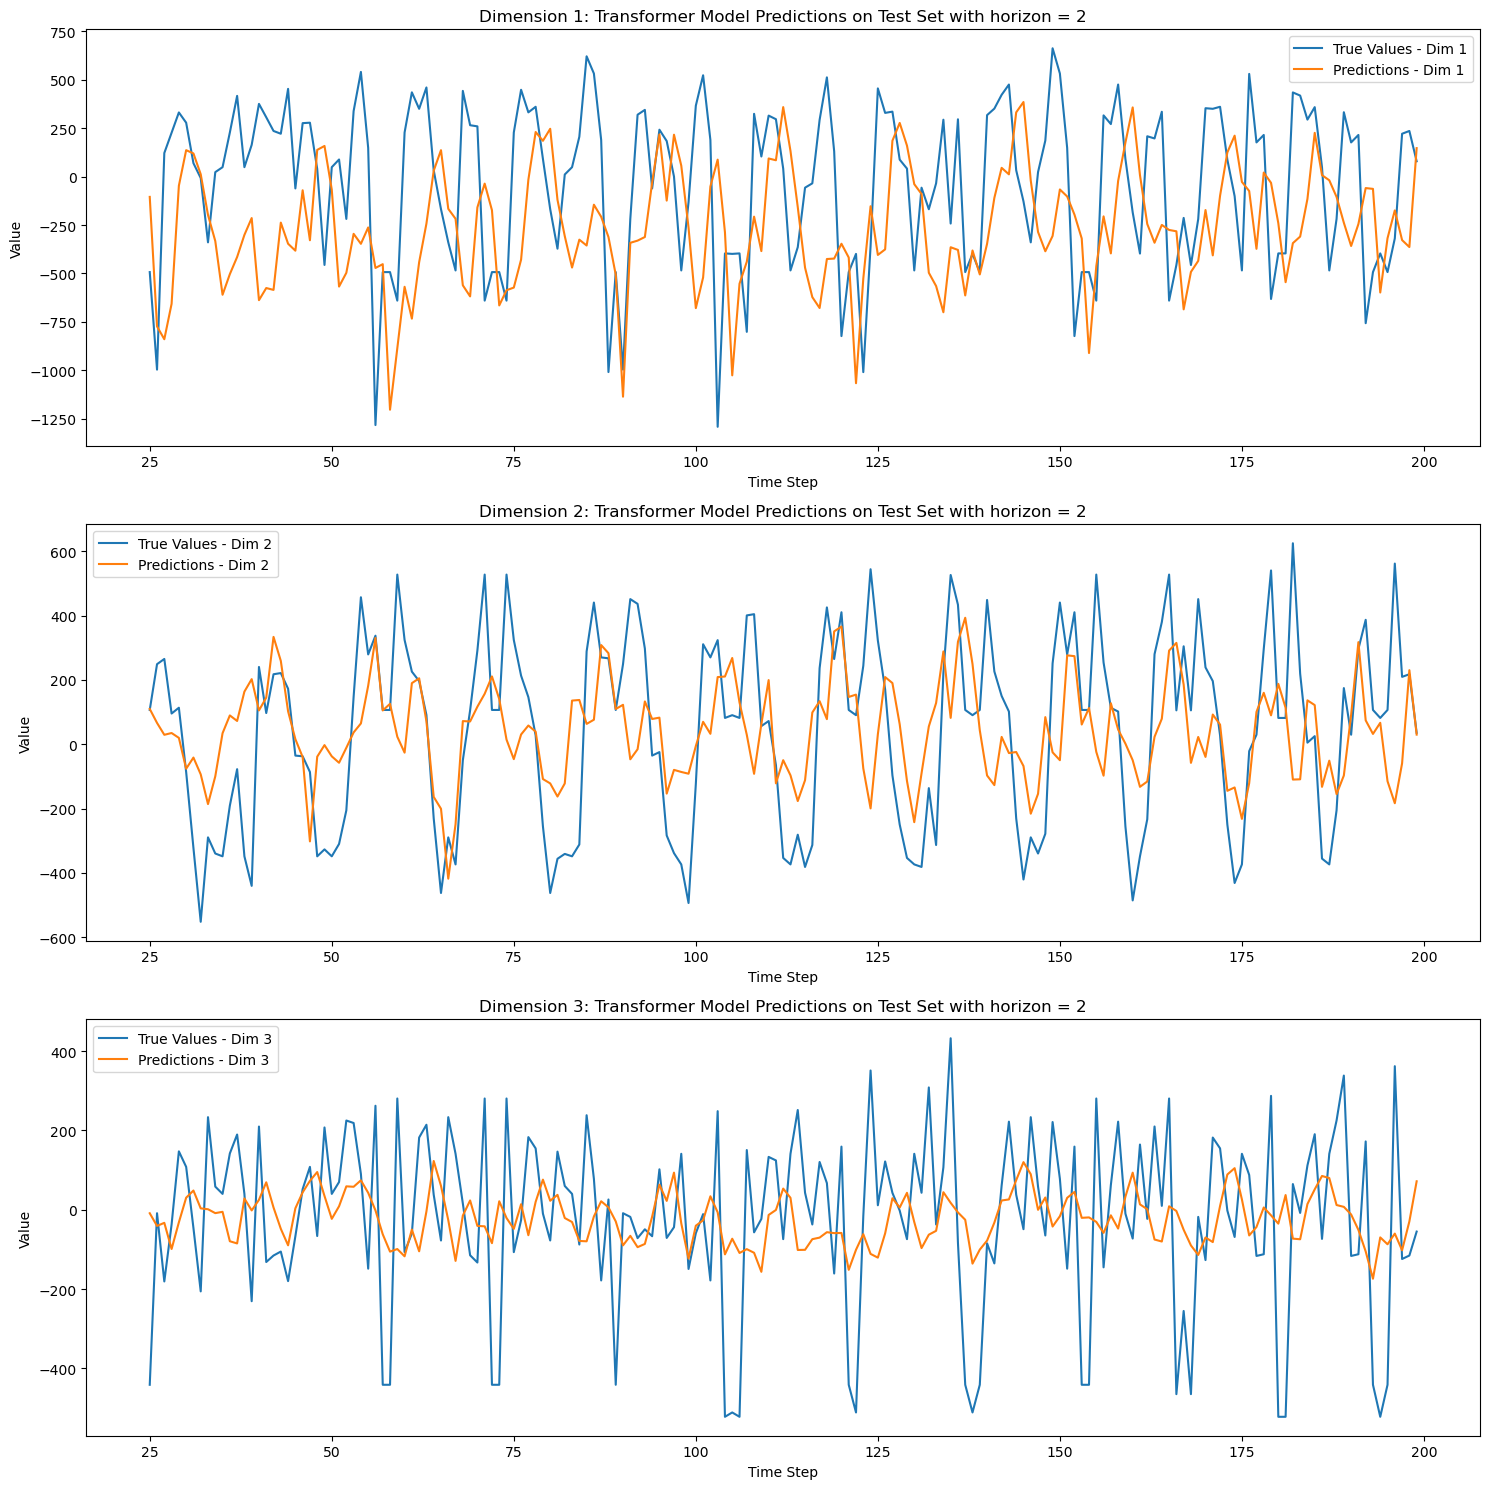

In [106]:
# Plot test predictions for each dimension
plt.figure(figsize=(15, 5 * n_features))
for i in range(n_features):
    plt.subplot(n_features, 1, i + 1)
    plt.plot(test_indices, test_targets_rescaled[:, i], label=f"True Values - Dim {i+1}")
    plt.plot(test_indices, test_predictions_rescaled[:, i], label=f"Predictions - Dim {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Dimension {i+1}: Transformer Model Predictions on Test Set with horizon = {horizon}")
    plt.legend()
plt.tight_layout()
plt.show()

In [107]:
# Calculate overall metrics across all dimensions
overall_mse = np.mean((test_predictions_rescaled - test_targets_rescaled) ** 2)
overall_rmse = np.sqrt(overall_mse)  # not the same as in Matlab / the paper
overall_mae = np.mean(np.abs(test_predictions_rescaled - test_targets_rescaled))

print(f"Overall performance metrics for horizon = {horizon}:")
print(f"Test MSE: {overall_mse:.4f}, RMSE: {overall_rmse:.4f}, MAE: {overall_mae:.4f}")

Overall performance metrics for horizon = 2:
Test MSE: 131873.2500, RMSE: 363.1436, MAE: 274.4481


In [108]:
# Auxiliary function - not sure yet about it but keeping that here in case...

import json


def load_model(model_path, config_path, device):
    """Load a trained model and its configuration"""
    # Load configuration
    with open(config_path, "r") as f:
        config = json.load(f)

    # Initialize model
    model = tf.init_model(config)

    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set model to evaluation mode

    return model, config


horizon_dir = os.path.join(model_output_dir, f"horizon_{horizon}")